In [1]:
import numpy as np

In [2]:
import weaviate
from weaviate.classes.config import Property, DataType, Configure
from weaviate import collections as col
from weaviate.classes.query import Filter
from weaviate.classes.init import AdditionalConfig, Timeout

client = weaviate.connect_to_local(
    additional_config=AdditionalConfig(
        timeout=Timeout(init=20, query=120, insert=120)  # Values in seconds
    ))

# Populate

## Hello-World Data

In [15]:
client.collections.create(
    "Article",
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
    generative_config=Configure().Generative().ollama(api_endpoint="http://weaviate_ollama_1:11434", model= "llama3"),
    vectorizer_config=Configure().Vectorizer().text2vec_ollama(api_endpoint="http://weaviate_ollama_1:11434")
)

UnexpectedStatusCodeError: Collection may not have been created properly.! Unexpected status code: 422, with response body: {'error': [{'message': 'class name Article already exists'}]}.

In [5]:
article = client.collections.get("Article")

In [9]:
uuid = article.data.insert({
    "title": "War in Mexico!",
    "body": "To find out more about this war, you need to know about General Juan.",
})

print(uuid)

358c7454-2da0-4018-bb29-462a31493ebf


In [10]:
uuid = article.data.insert({
    "title": "General Killed in Bolivia!",
    "body": "It was a tragic accident, involving alcohol.",
})

print(uuid)

7ff37c84-077b-4d14-9d4d-6a20c60eb02f


## ML Paper Dataset

In [78]:
from datasets import load_dataset

In [93]:
dataset = load_dataset("CShorten/ML-ArXiv-Papers")

Generating train split:   0%|          | 0/117592 [00:00<?, ? examples/s]

C:\Users\cdalz\src\repositories\weaviate_verba\.venv\Lib\site-packages\pandas\io\common.py:141: ResourceWarning:

unclosed file <_io.BufferedReader name='C:\\Users\\cdalz\\.cache\\huggingface\\datasets\\downloads\\3f6f69cdd892afd03084d260fe5678f805316cdbfde216136f7d390a95b3cae8'>



In [117]:
print(str(dataset.data["train"]["abstract"][9]))

  Max-product belief propagation is a local, iterative algorithm to find the
mode/MAP estimate of a probability distribution. While it has been successfully
employed in a wide variety of applications, there are relatively few
theoretical guarantees of convergence and correctness for general loopy graphs
that may have many short cycles. Of these, even fewer provide exact ``necessary
and sufficient'' characterizations.
  In this paper we investigate the problem of using max-product to find the
maximum weight matching in an arbitrary graph with edge weights. This is done
by first constructing a probability distribution whose mode corresponds to the
optimal matching, and then running max-product. Weighted matching can also be
posed as an integer program, for which there is an LP relaxation. This
relaxation is not always tight. In this paper we show that \begin{enumerate}
\item If the LP relaxation is tight, then max-product always converges, and
that too to the correct answer. \item If the

In [119]:
len(dataset.data["train"]["title"])

117592

In [113]:
paper = client.collections.create(
    "Paper",
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
    generative_config=Configure().Generative().ollama(api_endpoint="http://weaviate_ollama_1:11434", model= "llama3"),
    vectorizer_config=Configure().Vectorizer().text2vec_ollama(api_endpoint="http://weaviate_ollama_1:11434")
)

In [143]:
import tqdm

with paper.batch.dynamic() as batch:
    for t, a in tqdm.tqdm(zip(dataset.data["train"]["title"], dataset.data["train"]["abstract"]), total=len(dataset.data["train"]["title"])):
        batch.add_object(
            properties={
        "title": str(t),
        "body": str(a),
    }
        )

100%|██████████| 117592/117592 [3:01:09<00:00, 10.82it/s] 


# Delete

# Query

In [36]:
generate_prompt = "Produce a 10 word query for a vector database that would help me find out more, based on the search and the results."

response = article.generate.near_text(
    query="Mexico Battle",
    limit=1,
    grouped_task=generate_prompt
)

In [25]:
response = article.query.near_text(
    query="Mexico Battle",
    limit=1,
    distance=0.6,
    include_vector=True
)

In [37]:
print(response.generated)

What events led to General Juan's involvement in the Mexican War?

This query uses 10 words to help a vector database understand the context and intent behind the search. The query is designed to find information related to:

1. Events: The use of "What" suggests that you're looking for information about specific occurrences or happenings.
2. General Juan: By including his name, you're specifying the focus on this particular individual's involvement in the war.
3. Mexican War: The phrase "Mexican War" helps narrow down the search to a specific conflict.

The results would likely include information about the War of the Reform (1857-1861), the French Intervention in Mexico (1862-1867), or another relevant military conflict involving General Juan.


In [16]:
print(response.objects[0].properties)

{'title': 'War in Mexico!', 'body': 'To find out more about this war, you need to know about General Juan.'}


# Vectors

In [6]:
import plotly.express as px
import plotly.graph_objects as go

In [7]:
from scipy.stats import gaussian_kde
from scipy.integrate import nquad
import itertools

In [162]:
n_samples = 10000
vs = np.zeros((n_samples, 768))
for i, p in enumerate(paper.iterator(include_vector=True)):  # take n_samples from paper dataset
    vs[i] = p.vector["default"]
    if i == n_samples - 1:
        break

In [165]:
# KDE estimation
kde = gaussian_kde(vs.T, bw_method='scott')  # Scott's Rule for bandwidth

In [166]:
kdes = kde.pdf(vs.T)

print("Mean differential entropy over dataset:", np.mean(np.log2(kdes)))

Mean differential entropy over dataset: 778.6045164692936


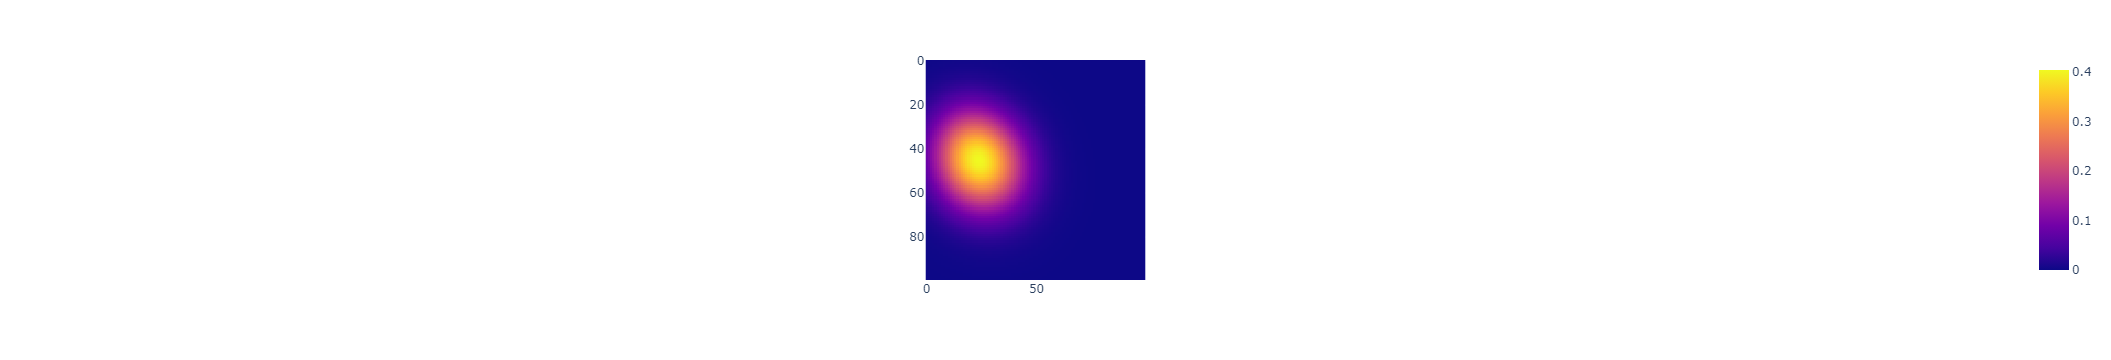

In [201]:
px.imshow(Z.reshape(N, N))

In [220]:
min_bounds = np.min(vs, axis=0)
max_bounds = np.max(vs, axis=0)

N = 30
dims = [500, 300, 100]

x = np.linspace(min_bounds[dims[0]], max_bounds[dims[0]], N)
y = np.linspace(min_bounds[dims[1]], max_bounds[dims[1]], N)
z = np.linspace(min_bounds[dims[2]], max_bounds[dims[2]], N)

X, Y, Z = np.meshgrid(x, y, z)

vals = kde.marginal(dims).pdf(np.array(list(itertools.product(x, y, z))).T)

In [221]:
np.max(vals)

np.float64(0.26743901054322317)

In [228]:
go.Figure(go.Volume(x=X.flatten(), y=Y.flatten(), z=Z.flatten(), value=vals.flatten(),
                   isomin=0.01,
                   isomax=np.max(vals),
                   surface_count=17,
                   opacity=0.1)).update_layout(height=1000)

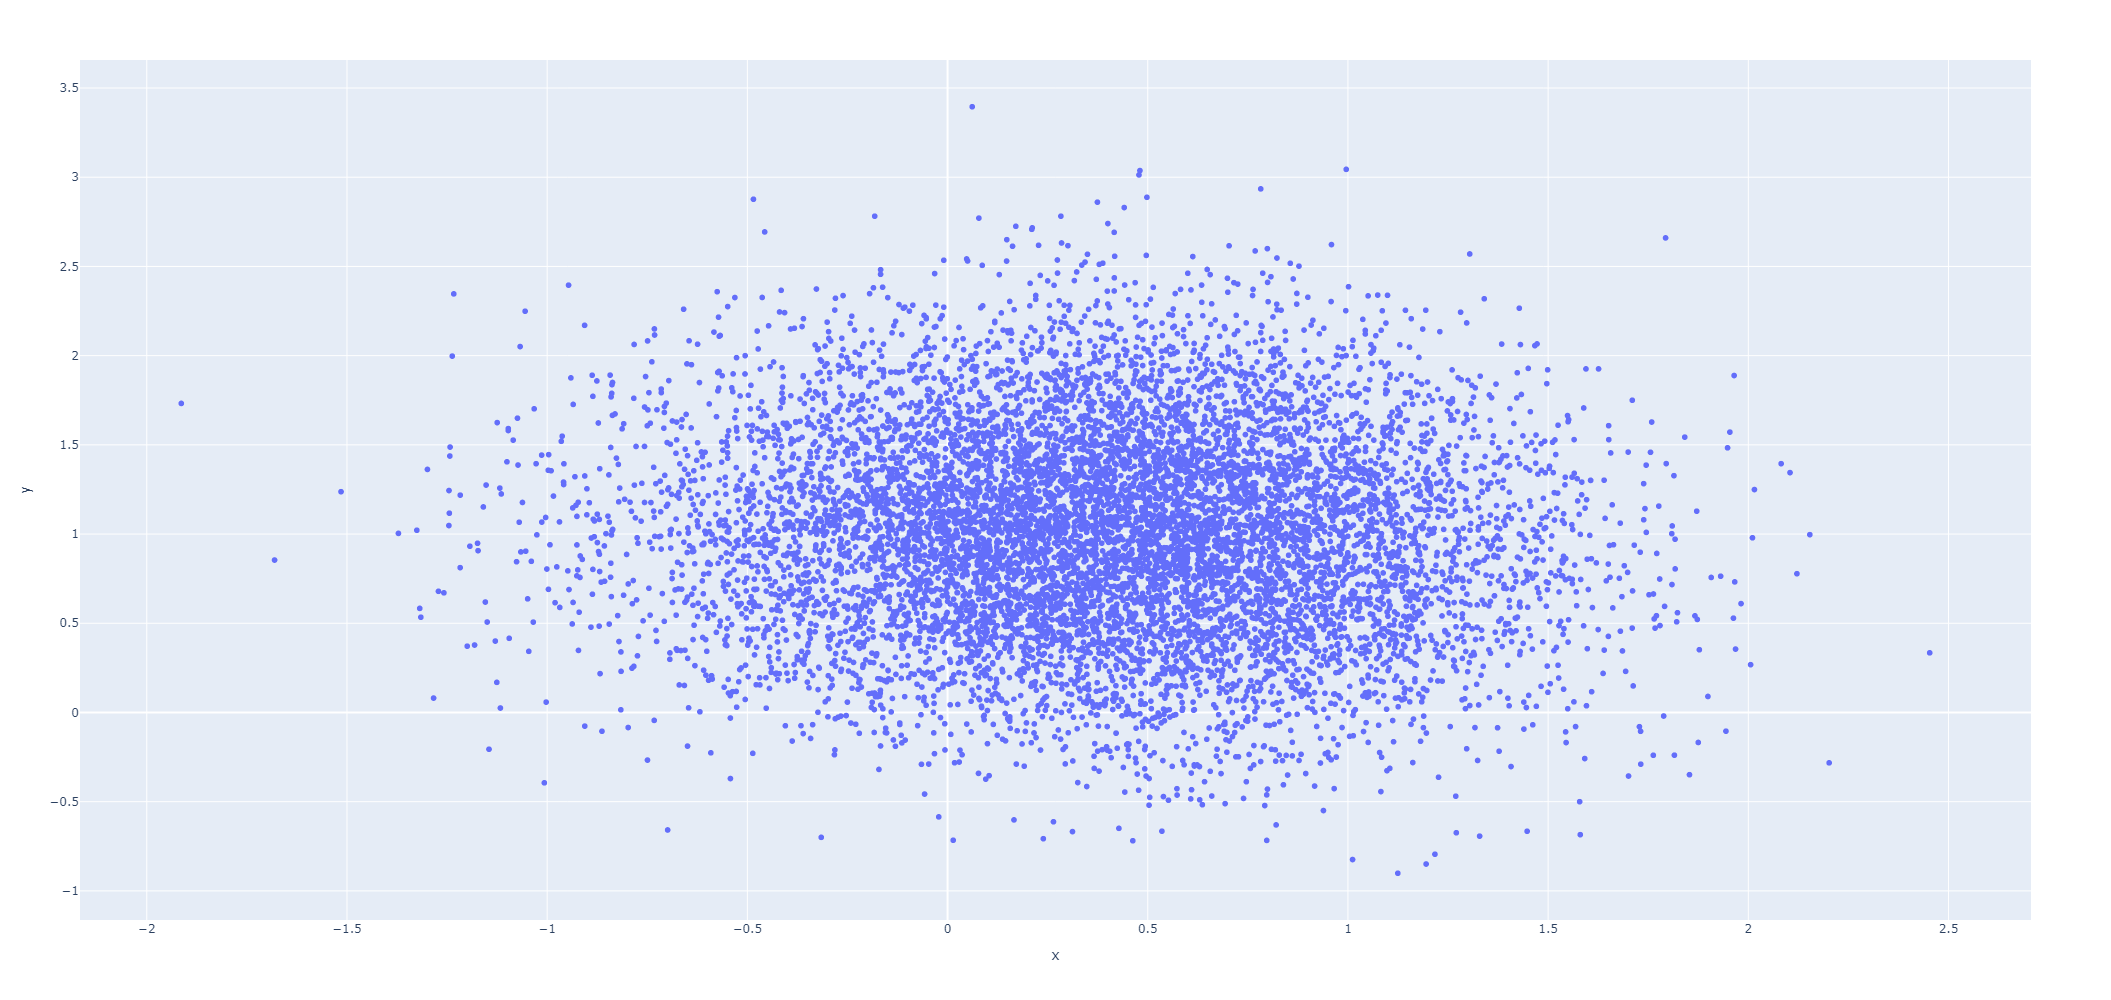

In [178]:
px.scatter(x=vs[:, 0], y=vs[:, 1]).update_layout(height=1000, width=1000)

In [168]:
from sklearn.decomposition import PCA

In [184]:
pca = PCA(n_components=768)
pca.fit(vs)

PCA(n_components=768)

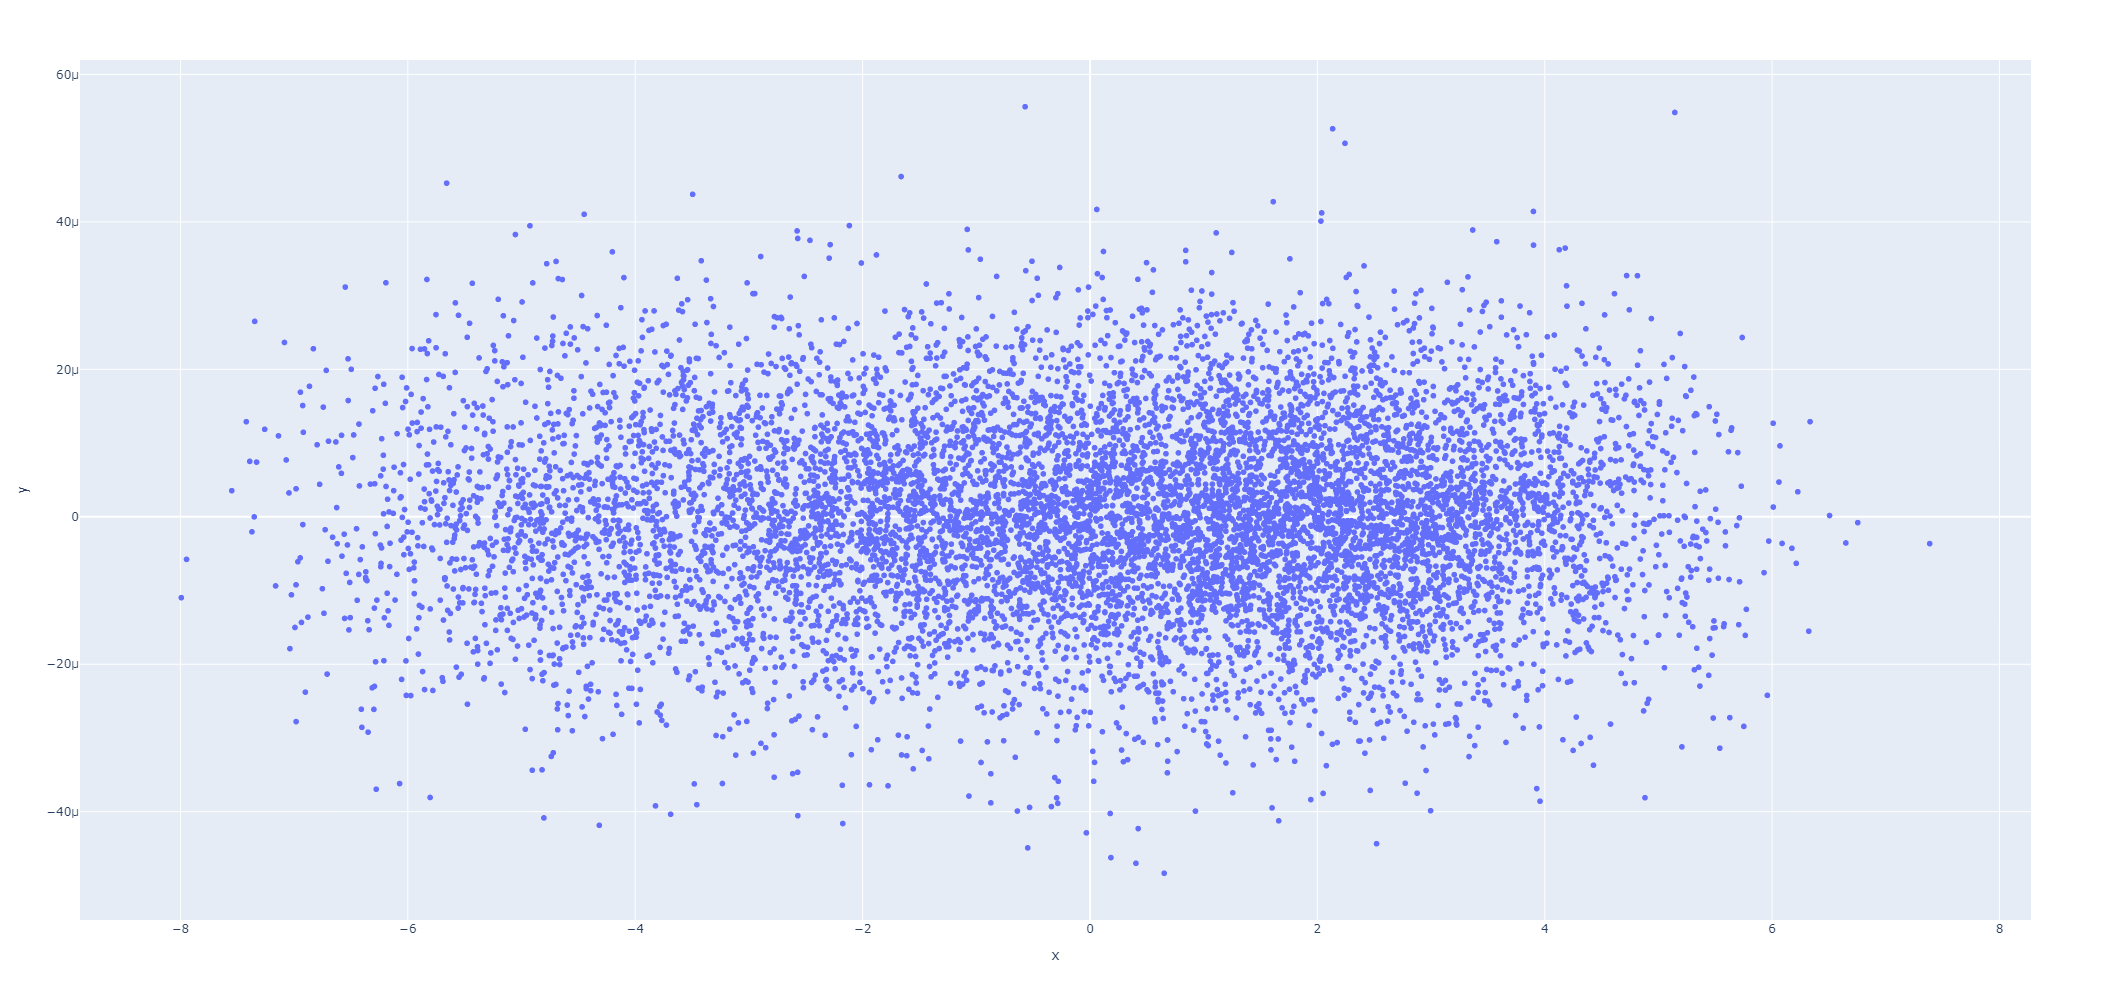

In [187]:
trans_vs = pca.transform(vs)
px.scatter(x=trans_vs[:, 0], y=trans_vs[:, -1]).update_layout(height=1000, width=1000)

In [186]:
print(pca.explained_variance_ratio_)

[5.00080634e-02 3.61742244e-02 3.24140886e-02 2.54835252e-02
 2.47836874e-02 2.19554405e-02 2.03755065e-02 1.95758744e-02
 1.66558530e-02 1.60333833e-02 1.38351729e-02 1.27316216e-02
 1.17689046e-02 1.14890503e-02 1.10585768e-02 1.08299791e-02
 1.02853384e-02 9.55352959e-03 9.29025675e-03 9.02200061e-03
 8.68758608e-03 8.39256016e-03 8.00018495e-03 7.78306726e-03
 7.69594659e-03 7.42655661e-03 7.14448026e-03 6.85964433e-03
 6.71917627e-03 6.62543367e-03 6.37592635e-03 6.37004394e-03
 6.22900702e-03 5.99664158e-03 5.85655303e-03 5.67148815e-03
 5.57174264e-03 5.47073911e-03 5.37882702e-03 5.19648984e-03
 5.13342464e-03 5.05809104e-03 4.99429382e-03 4.91310238e-03
 4.85259574e-03 4.63833078e-03 4.58449330e-03 4.48925039e-03
 4.42390763e-03 4.37599158e-03 4.31363254e-03 4.22500673e-03
 4.17978320e-03 4.12098597e-03 4.07163882e-03 4.01577234e-03
 3.97895281e-03 3.85804262e-03 3.79832262e-03 3.78505462e-03
 3.72472052e-03 3.67103215e-03 3.60493227e-03 3.57400800e-03
 3.49958010e-03 3.434338